In [1]:
with open('sequences20') as handle:
    u = handle.read()
import json
seqs_by_length = json.loads(u)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
from sympy import ntheory
from sympy.ntheory import continued_fraction_reduce
import matplotlib.colors as mcolors
import time

In [3]:
# The matrix for an EVEN LENGTH R-L sequence
def cf2matrix(a):
    u = np.eye(2, dtype=np.int64)
    for x in a:
        u = np.matmul(u, [[x, 1], [1, 0]])
    return u

# The matrix for an even or odd length sequence, where the odd case is just the "condensed form" for an even sequence
def m_rep(seq):
    if len(seq) % 2 == 0:
        return cf2matrix(seq)
    else:
        return cf2matrix(seq + seq)
    
def rotl(x, k):
    return x[k:] + x[:k]

def min_rot(x):
    return min(rotl(x, k) for k in range(len(x)))

def min_rot2(x):
    return min(rotl(x, k) for k in range(0, len(x), 2))
    
def trace2length(t):
    return 2 * np.arccosh(t/2)

def length2trace(l):
    return 2 * np.cosh(l/2)

# The sequences that we actually want, from the "condensed forms" that take primitive roots in PGL_2(Z)
def actual_sequences(a, length):
    min_trace = int(length2trace(length)) + 1
    max_trace = int(length2trace(length+1)) + 1
    result = []
    for _x in a:
        x = _x[:] # Need this to make x harmlessly mutable
        m = m_rep(x)
        t = np.trace(m)
        if t < min_trace or t >= max_trace:
            x_length = trace2length(t)
            k = int((length + 1)/x_length)
            x *= k
        # Symmetrize by both R-L flip and time reversal, and add all four
        if len(x) % 2 == 0:
            result += [x, rotl(x, 1)]
        # Expand condensed form, and then symmetrize by time reversal
        else:
            xx = x + x
            result += [xx]
    return result

def my_actual_sequences(length):
    return actual_sequences(seqs_by_length[length], length)

def reduce_and_remove_duplicates(seqs):
    u = {tuple(min_rot2(x)) for x in seqs}
    return [list(x) for x in u if min_rot2(x[::-1]) != x]
            
def guys_for_trace(t):
    l = int(trace2length(t))
    l_seqs = my_actual_sequences(l)
    t_seqs = [x for x in l_seqs if np.trace(cf2matrix(x)) == t]
    return reduce_and_remove_duplicates(t_seqs)
    
def geos_in_trace_range(t0,t1):
    all_seqs = []
    for i in range(t0,t1+1):
        all_seqs += guys_for_trace(i)
    return all_seqs

In [4]:
def cfListToDicts(cfList):
    forwardDict = {}
    invDict = {}
    for cf in cfList:
        for obj in split(cf):
            if obj[0] in forwardDict:
                forwardDict[obj[0]].add(obj[1])
            else:
                forwardDict[obj[0]] = {obj[1]}
            if obj[1] in invDict:
                invDict[obj[1]].add(obj[0])
            else:
                invDict[obj[1]] = {obj[0]}
    return forwardDict,invDict

def permutationsOf(a):
    perms = []
    if len(a)%2==0:
        for n in range(0,len(a),2):
            perms.append(a[n:]+a[:n])
    else:
        for n in range(0,len(a)):
            perms.append(a[n:]+a[:n])
    return perms

def inv(lrSeq): #inverts a list of 0's and 1's (R's and L's)
    return tuple((np.array(lrSeq[::-1])-1)**2)

def split(contFrac): #splits a cont'd fraction on every possible pair of R's into 2 groups of R's and L's (in 0's and 1's)
    output = []
    converted = contFracToLR(contFrac)
    n = len(converted)
    splitPoints = pairs(converted)
    for i,j in splitPoints:
        temp = converted[i:]+converted[:i]
        temp1 = temp[1:(j-i)%n]
        temp2 = inv(temp[(j-i)%n+1:]) #inv(temp[(j-i)%n+1:])
        output.append((tuple(temp1),tuple(temp2)))
    return output

def contFracToLR(contFrac):
    if len(contFrac)%2==1:
        contFrac = contFrac + contFrac
    output = []
    for i in range(len(contFrac)):
        if i%2==1: #if original cont'd frac is even length, making last one R/alternating is same as this (hopefully)
            for j in range(contFrac[i]):
                output.append(1)
        else:
            for j in range(contFrac[i]):
                output.append(0)
    return output

def indices(lrSeq): #positions of R's (R=1)
    return [i for i in range(len(lrSeq)) if lrSeq[i]==1]

def pairs(lrSeq): #pairs of R's on which to split
    output = []
    for i in indices(lrSeq):
        for j in indices(lrSeq):
            if i==j:
                continue
            else:
                output.append((i,j))
    return output

def recover2(ls): #sends a whole list to a cont'd fraction (not clear whether this is needed)
    output = []
    i=0
    while i<len(ls):
        counter=1
        while(i<len(ls)-1 and ls[i] == ls[i+1]):
            i+=1
            counter+=1
        i+=1
        output.append(counter)
    if (len(output)%2!=0):
        output[len(output)-1]+=output[0]
        output = output[1:]
    return output

def pairToFrac(s1,s2):
    out = list(s1)+[1]+list(inv(s2))+[1]
    return tuple(min(permutationsOf(recover2(out))))

def getPants(cfList):
    dictPair = cfListToDicts(cfList)
    forwardDict = dictPair[0]
    invDict = dictPair[1]
    pants = set()
    for s0 in forwardDict:
        for s1 in forwardDict[s0]:
            if s1 in forwardDict and s0 in invDict:
                for s2 in forwardDict[s1].intersection(invDict[s0]):
                    y0,y1,y2 = pairToFrac(s0,s1),pairToFrac(s1,s2),pairToFrac(s2,s0)
                    if y0==y1 or y1==y2 or y0==y2:
                        continue
                    pants.add(frozenset((y0,y1,y2)))
    return pants

def pantsInTraceRange(traceMin,traceMax):
    cfList = []
    for trace in range(traceMin,traceMax+1):
        cfList += guys_for_trace(trace)
    return getPants(cfList)

def boundByCuff(pantSet,cuttingSequence):
    pantsWithCuff = []
    seq = min(permutationsOf(cuttingSequence))
    for pants in pantSet:
        if seq in pants:
            pantsWithCuff.append(pants)
    return pantsWithCuff

def boundary(pantSet,seq): 
    inv = seq[::-1]
    return (len(boundByCuff(pantSet,seq)) - len(boundByCuff(pantSet,inv)))
            

def cfToMat(cf):
    mat = np.identity(2)
    length = 0
    for x in cf:
        mat = np.matmul(mat,[[x,1],[1,0]])
        length += 1
    if length % 2 == 1:
        mat = np.matmul(mat,mat)
    return np.array(mat).astype(int)


def pantsToGeodesics(pList):
    positives = list()
    for p in pList:
        for geo in p:
            minGeo = min(permutationsOf(geo))
            invGeo = min(permutationsOf(minGeo[::-1]))
            if minGeo in positives or invGeo in positives:
                continue
            else:
                positives.append(minGeo)
    return positives
                
def geosToEyes(geos):
    eyes = list()
    for geo in geos:
        for i in range(0,len(geo),2):
            a = list(geo[i:])+list(geo[:i])
            a = a[1:]
            a[0]-=1
            a[len(a)-1]-=1
            eyes.append((geo,tuple(a)))
    return eyes

def cuspInv(cusp):
    invCusp = list(cusp[::-1])
    if len(invCusp) == 1 and invCusp[0] <= 0:
        return tuple(invCusp)
    else:
        if invCusp[0] == 0:
            invCusp = invCusp[1:]
        else:
            invCusp = [0] + invCusp
        if invCusp[-1] == 0:
            invCusp = invCusp[:-1]
        else:
            invCusp = invCusp + [0]
        return tuple(invCusp)

def eyesToCusps(eList):
    output = list()
    for e in eList:
        eye = e[1]
        invEye = cuspInv(eye)
        if eye in output or invEye in output:
            continue
        else:
            output.append(eye)
    return output
                
def pantsAndEyesToMatrix(pantList, eyeList, posGeoList, posCuspList):
    
    geoIndexDict = {}
    cuspIndexDict = {}
    
    basisList = posGeoList + posCuspList
    
    for i in range(len(basisList)):
        if i < len(posGeoList):
            geoIndexDict[posGeoList[i]] = i 
        else:
            cuspIndexDict[posCuspList[i-len(posGeoList)]] = i
        
    colList = []
    for pants in pantList:
        col = np.zeros(len(basisList))
        for geo in pants:
            if geo in geoIndexDict:
                col[geoIndexDict[geo]] = 1
            else:
                col[geoIndexDict[min(permutationsOf(geo[::-1]))]] = -1
        colList.append(col)
    
    for eye in eyeList:
        col = np.zeros(len(basisList))
        
        if eye[0] in geoIndexDict:
            col[geoIndexDict[eye[0]]] = 1
        else:
            col[geoIndexDict[min(permutationsOf(eye[0][::-1]))]] = -1
        
        if eye[1] in cuspIndexDict:
            col[cuspIndexDict[eye[1]]] = 1
        else:
            col[cuspIndexDict[cuspInv(eye[1])]] = -1
        
        colList.append(col)
    
    return np.column_stack(colList)

In [5]:
def height(geo):
    alpha = ntheory.continued_fraction_reduce([geo])
    alpha_conj = -1/(ntheory.continued_fraction_reduce([geo[::-1]]))
    h = abs(alpha-alpha_conj)/2
    return h.evalf()

In [6]:
def hPant(pants):
    return max([height(list(g)) for g in pants])

In [7]:
def hEye(eye):
    return height(list(eye[0]))

In [8]:
def bPant(pantList,pants):
    pants = list(pants)
    geo = pants[np.argmax([height(list(g)) for g in pants])]
    output  = abs(boundary(pantList,geo))
    return output

In [9]:
def plotBvH(boundsP, heightsP, n = 12):
    numP = len(boundsP)
    fig = plt.figure()
    n = 12
    sections = np.histogram(heightsP,  bins = n, range = (0,float(np.mean(heightsP)+.5*np.var(heightsP))))
    output = []
    for i in range(1,len(sections[1])):
        Lis = [boundsP[p] for p in range(numP) if heightsP[p]<sections[1][i] and heightsP[p]>sections[1][i-1]]
        output.append((np.mean(Lis),np.var(Lis)))
    x = [(sections[1][i]+sections[1][i-1])/2 for i in range(1,len(sections[1]))]
    y = [u for (u,v) in output]
    yerror = [v for (u,v) in output]
    plt.errorbar(x,y,yerr  = yerror, capsize = 5.0, capthick = 2.0)
    plt.xlabel('height of pants')
    plt.ylabel('boundary size')
    plt.show()

In [10]:
def printTime():
    currentTime = [time.localtime().tm_hour, time.localtime().tm_min]
    if currentTime[1]<10:
        currentTime[1] = '0'+str(currentTime[1])
    if currentTime[0]<12 and currentTime[0]>0:
        print(f"The time is currently {currentTime[0]}:{currentTime[1]} am.")
    elif currentTime[0]==12:
        print(f"The time is currently {currentTime[0]}:{currentTime[1]} pm.")
    elif 12<currentTime[0]:
        print(f"The time is currently {currentTime[0]-12}:{currentTime[1]} pm.")
    else:
        print(f"The time is currently 12:{currentTime[1]} am.")

In [11]:
def printExpectedTime(tm, string):
    if tm==0:
        return
    elif tm==1:
        print(f"Expect to wait approximately 1 minute for {string} to be computed.")
    elif tm<60:
        print(f"Expect to wait approximately {round(tm)} minutes for {string} to be computed.")
    elif int(tm//60)==1:
        if int(round(tm%60))!=1:
            print(f"Expect to wait approximately 1 hour and {int(round(tm%60))} minutes for {string} to be computed.")
        else:
            print(f"Expect to wait approximately 1 hour and 1 minute for {string} to be computed.")
    else:
        if int(round(tm%60))!=1:
            print(f"Expect to wait approximately {int(tm//60)} hours and {int(round(tm%60))} minutes for {string} to be computed.")
        else:
            print(f"Expect to wait approximately {int(tm//60)} hours and 1 minute for {string} to be computed.")

In [75]:
def graphAndReturn(mini,maxi,short = False, weights = (1,0)):
    pantsSet = pantsInTraceRange(mini,maxi)
    posGeoList = pantsToGeodesics(pantsSet)
    eyeList = geosToEyes(posGeoList)
    posCuspList = eyesToCusps(eyeList)
    pantsList = list(pantsSet)
    A = pantsAndEyesToMatrix(pantsList,eyeList,posGeoList,posCuspList)
    numP = len(pantsList)
    numE = len(eyeList)
    numG = len(posGeoList)
    print(f"The matrix A has the shape {A.shape}.\n")
    #cvxpy without integer constraints
    print("trace range = " + str((mini,maxi)))
    resultList = pantsList+eyeList
    startTime = time.time()
    P = np.diag([weights[0]]*numP + [weights[1]]*numE)
    # input
    b = np.zeros(A.shape[0])
    # Construct a CVXPY problem
    x = cp.Variable(A.shape[1],nonneg = True)
    objective = cp.Minimize(cp.quad_form(x,P))
    constraints = []
    constraints.append(A@x==b)
    constraints.append(cp.sum(x) == 10**6) #scaled solutions
    prob = cp.Problem(objective,constraints)
    prob.solve()

    n_bins = 20

    pVals = x.value[:numP]
    eVals = x.value[numP:]
    endTime = time.time()
    timeElapsed = endTime-startTime
    if timeElapsed<60:
        print(f"It took {round(timeElapsed)} seconds to solve the quadratic program.\n")
    else:
        mins = int(timeElapsed//60)
        if mins>1:
            print(f"It took {mins} minutes and {round(timeElapsed%60)} seconds to solve the quadratic program.\n")
        else:
            print(f"It took 1 minute and {round(timeElapsed%60)} seconds to solve the quadratic program.\n")
    
    print(f"P = ({weights[0]},{weights[1]})")
    print("pants sum: " + str(sum(pVals)))
    print("avg pants cf: " + str(sum(pVals)/numP))
    print("eyes sum: " + str(sum(eVals)))
    print("avg eyes cf: " + str(sum(eVals)/numE))
    print("pants variance: " + str(np.var(pVals)))
    print("eyes variance: " + str(np.var(eVals)))

    fig, axs = plt.subplots(1, 2, tight_layout=True)

    axs[0].hist(pVals, bins=n_bins)
    axs[1].hist(eVals, bins=n_bins)
    axs[0].set_ylabel('number of pants')
    axs[1].set_ylabel('number of eyes')
    axs[0].set_xlabel('weight')
    axs[1].set_xlabel('weight')
    plt.show()
    
    if short:
        return (pVals, eVals)
    
    geosPerMin = 250
    ExpectedTimeForPantsHeights = numG/geosPerMin
    printExpectedTime(ExpectedTimeForPantsHeights, "heights")
    printTime()
    heights = [height(list(geo)) for geo in posGeoList]
    print("completed computing heights!\n")
    
    print("now computing pants' heights:")
    heightsP = np.amax(np.array(np.diag(heights),dtype = np.float64) @ A[:numG,:numP], axis = 0)
    print("completed computing pants' heights!\n")

    print("now computing eyes' heights:")
    heightsE = np.amax(np.array(np.diag(heights),dtype = np.float64) @ A[:numG,numP:], axis = 0)
    print("completed computing eyes' heights!\n")

    print("now computing geodesics' boundaries:")
    boundsG = [int(i) for i in list(abs(np.dot(A,np.array([1]*(numP)+[0]*(numE)))))]
    print("completed computing geodesics' boundaries!\n")
    
    print("now computing pants' boundaries:")
    boundsP = [int(abs(i)) for i in np.amax(np.array(np.diag(boundsG),dtype = np.float64) @ A[:numG,:numP], axis = 0)]
    print("completed computing pants' boundaries")
    #solList = list(zip(resultList,x.value))
    #solList.sort(key=lambda x:x[1], reverse=True)
    #resultStr = ""
    #for x in solList:
    #    resultStr += "+" + str(x[1]) + "*" + str(x[0]) + "\n"
    #print(resultStr)
    
    return (pVals, eVals, heightsP, heightsE, boundsP)

In [76]:
def grapher(pVals, eVals, heightsP, heightsE, boundsP):
    
    n_bins = 20
    
    fig, axs = plt.subplots(1, 4, tight_layout=True)

    axs[0].scatter(heightsP, pVals)
    axs[1].scatter(heightsE, eVals)
    axs[2].scatter(boundsP, pVals)
    axs[3].scatter(heightsP, boundsP)

    axs[0].set_xlabel('height of pants')
    axs[1].set_xlabel('height of eyes')
    axs[2].set_xlabel('size of boundary')
    axs[3].set_xlabel('height of pants')

    axs[0].set_ylabel('copies of each pants')
    axs[1].set_ylabel('copies of each pants')
    axs[2].set_ylabel('copies of each pants')
    axs[3].set_ylabel('size of boundary')

    plt.show()

    fig, axs = plt.subplots(1, 4, tight_layout=True)
    a,b = np.median(heightsP)+np.var(heightsP),np.median(pVals)+0.03*np.var(pVals)
    a,b = round(a), round(b)
    c,d = np.median(heightsE)+2*np.var(heightsE),np.median(eVals)+.005*np.var(eVals)
    c,d = round(c), float(d)
    e,f = np.median(boundsP)+np.var(boundsP),np.median(pVals)+0.25*np.var(pVals)
    e,f = round(e), round(f)
    g,h = np.median(heightsP)+np.var(heightsP),np.median(boundsP)+1*np.var(boundsP)
    g,h = round(g), round(h)


    axs[0].hist2d(heightsP, pVals, bins  = n_bins, range = [[0,a],[0,b]], normed = True, norm = mcolors.PowerNorm(.2))
    axs[1].hist2d(heightsE, eVals, bins  = n_bins, range = [[0,c],[0,d]], normed  = True, norm = mcolors.PowerNorm(.2))
    axs[2].hist2d(boundsP,pVals, bins = n_bins, range = [[0,e],[0,f]], normed = True, norm  = mcolors.PowerNorm(.2))
    axs[3].hist2d(heightsP, boundsP, bins  = n_bins, range = [[0,g],[0,h]], normed = True, norm = mcolors.PowerNorm(.2))

    axs[0].set_xlabel('height of pants')
    axs[1].set_xlabel('height of eyes')
    axs[2].set_xlabel('size of boundary')
    axs[3].set_xlabel('height of pants')

    axs[0].set_ylabel('number of pants')
    axs[1].set_ylabel('number of eyes')
    axs[2].set_ylabel('copies of each pants')
    axs[3].set_ylabel('size of boundary')

    plt.show()

    plotBvH(boundsP, heightsP)

trace range = (200, 250)
P = (1,0)
pants sum: 477336.7119203562
avg pants cf: 19.10340224598216
eyes sum: 523890.51868239365
avg eyes cf: 214.79726063238772
pants variance: 314.83304008383004
eyes variance: 126236.34536491167


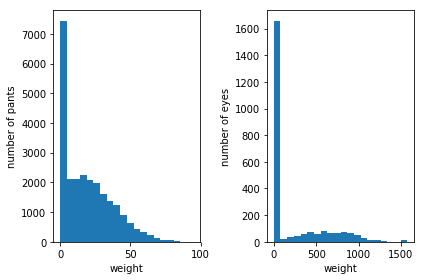

Expect to wait approximately 1 hours and 40 minutes for pants' heights to be computed
The time is currently 6:15 pm
completed computing pants' heights!
Expect to wait approximately 3 minutes for eyes' heights to be computed
The time is currently 7:50 pm
completed computing eyes' heights!
Expect to wait approximately 1 hours and 44 minutes for boundaries to be computed
The time is currently 7:53 pm
completed computing pants' boundaries!


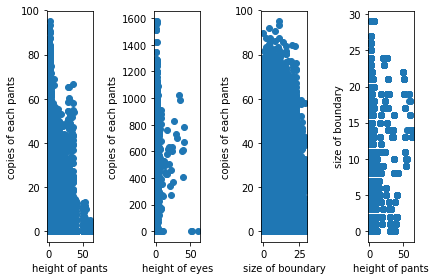

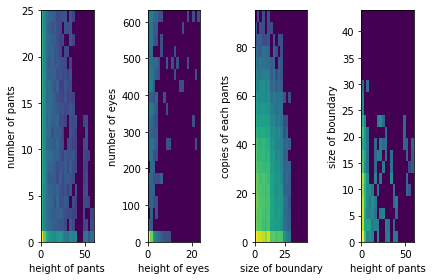

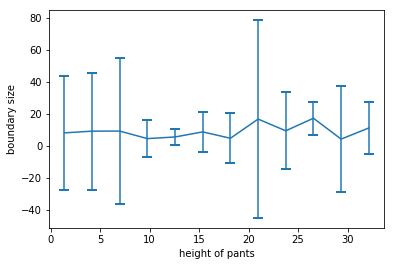

In [276]:
pVals_200_250, eVals_200_250, heightsP_200_250, heightsE_200_250, boundsP_200_250 = graphAndReturn(200,250)
grapher(pVals_200_250, eVals_200_250, heightsP_200_250, heightsE_200_250, boundsP_200_250)

The matrix A has the shape (331, 3959).

trace range = (30, 60)
It took 8 seconds to solve the quadratic program.

P = (1,0)
pants sum: 388985.43426084856
avg pants cf: 105.81758276954531
eyes sum: 616182.2106958411
avg eyes cf: 2177.3222992785904
pants variance: 25830.85874065153
eyes variance: 11771206.277141612


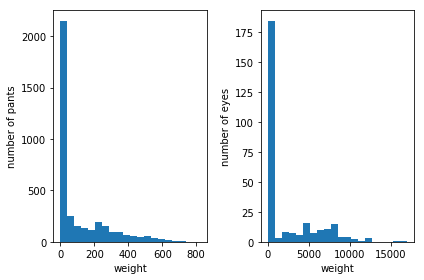

Expect to wait approximately 1 minutes for heights to be computed.
The time is currently 5:31 pm.
completed computing heights!

now computing pants' heights:
completed computing pants' heights!

now computing eyes' heights:
completed computing eyes' heights!

now computing geodesics' boundaries:
completed computing geodesics' boundaries!

now computing pants' boundaries:


ValueError: shapes (331,331) and (167,3676) not aligned: 331 (dim 1) != 167 (dim 0)

In [77]:
pVals_30_60, eVals_30_60, heightsP_30_60, heightsE_30_60, boundsP_30_60 = graphAndReturn(30,60)
grapher(pVals_30_60, eVals_30_60, heightsP_30_60, heightsE_30_60, boundsP_30_60)
print(heightsP_30_60[:30], boundsP_30_60[:30])

The matrix A has the shape (4241, 45486).

trace range = (250, 310)
It took 38 minutes and 55 seconds to solve the quadratic program.

P = (1,0)
pants sum: 500994.8931054194
avg pants cf: 11.957489453086529
eyes sum: 499379.7528787822
avg eyes cf: 139.18053313232502
pants variance: 113.96421083681108
eyes variance: 61998.315634013816


/Users/Kai/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


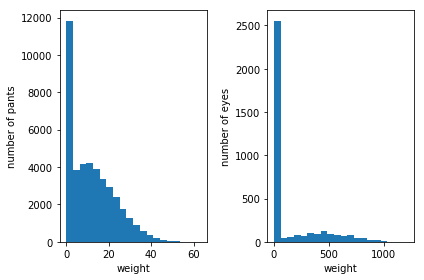

Expect to wait approximately 2 hours and 48 minutes for pants' heights to be computed.
The time is currently 1:36 am.
completed computing pants' heights!

Expect to wait approximately 5 minutes for eyes' heights to be computed.
The time is currently 4:17 am.
completed computing eyes' heights!

Expect to wait approximately 2 hours and 55 minutes for boundaries to be computed.
The time is currently 4:21 am.
completed computing pants' boundaries!



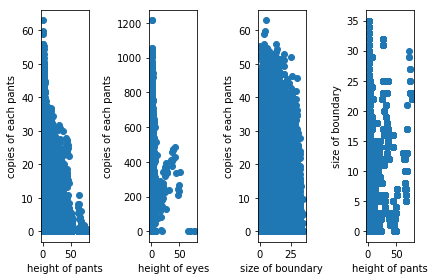

NameError: name 'n_bins' is not defined

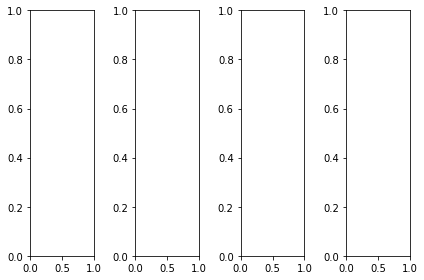

In [15]:
pVals_300_380, eVals_300_380, heightsP_300_380, heightsE_300_380, boundsP_300_380 = graphAndReturn(250,310)
grapher(pVals_300_380, eVals_300_380, heightsP_300_380, heightsE_300_380, boundsP_300_380)